In [1]:
%load_ext google.cloud.bigquery

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['agg.path.chunksize'] = 10000

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information from over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 15 years ago. So if today is 2024.05.17 then the weather we want to forecast is for the date 2009.05.18. You are supposed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to use BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck in the first part, you can use the replacement data provided in the second part

# Framing the Problem

The primary goal is to predict whether it will snow on a specific future date (i.e., tomorrow) as of 15 years ago from today, using historical weather data from a subset of stations (as mentioned in the subsequent tasks). 

Given the temporal nature of weather data and the binary nature of the prediction (snow or no snow), we'll consider both time series and classification techniques. We'll include temporal features (ed. day of the year) and lag features (eg. previous days' weather conditions) and then create a target label indicating whether it snowed the day after each record.

### Outline

1. Data Loading (using BigQuery)
2. Data Cleaning (handling missing values, anomalies, and ensuring data consistency)
3. Correlations (studying the relationship between show and other features in the data)
4. Feature Engineering (creatings lags and interaction terms)
5. Model Selection and Evaluation:

### Data Loading

In [4]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'learnings-426212-66dd48ee51b2.json'

In [5]:
from google.cloud import bigquery

# Set up your project ID
project_id = 'learnings-426212'

# Create a BigQuery client
client = bigquery.Client(project=project_id)

In [6]:
%%bigquery 
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/job/query.py:2051: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,37950,99999,1929,12,5,48.700001,4,45.500000,4,992.299988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
1,31590,99999,1929,10,2,50.200001,4,46.299999,4,987.000000,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
2,38640,99999,1929,10,1,55.000000,4,44.700001,4,1015.299988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
3,38110,99999,1929,12,8,48.700001,4,41.700001,4,993.900024,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
4,30050,99999,1929,12,27,42.500000,4,37.700001,4,991.200012,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
5,38110,99999,1929,10,4,53.299999,4,43.500000,4,1008.700012,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
6,38560,99999,1929,10,20,52.000000,4,42.299999,4,995.500000,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
7,30910,99999,1929,10,4,43.799999,4,NaN,<NA>,1002.700012,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
8,38940,99999,1929,11,11,50.799999,4,48.000000,4,1016.299988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
9,38640,99999,1929,11,1,44.700001,4,37.700001,4,1029.400024,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False


### Part 1

Check data type of each column

In [7]:
%%bigquery 
SELECT 
  column_name, data_type
FROM 
  `bigquery-public-data.samples.INFORMATION_SCHEMA.COLUMNS`
WHERE 
  table_name = 'gsod'


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/job/query.py:2051: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,column_name,data_type
0,station_number,INT64
1,wban_number,INT64
2,year,INT64
3,month,INT64
4,day,INT64
5,mean_temp,FLOAT64
6,num_mean_temp_samples,INT64
7,mean_dew_point,FLOAT64
8,num_mean_dew_point_samples,INT64
9,mean_sealevel_pressure,FLOAT64


### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [8]:
%%bigquery df 
SELECT 
  *,
  CONCAT(CAST(year AS STRING), '-', LPAD(CAST(month AS STRING), 2, '0'), '-', LPAD(CAST(day AS STRING), 2, '0')) AS date
FROM 
  `bigquery-public-data.samples.gsod`
WHERE 
  station_number BETWEEN 725300 AND 726300
  AND year BETWEEN 2005 AND 2009

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/job/query.py:2051: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [9]:
df.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
0,725835,99999,2005,1,2,23.000000,4,19.400000,4,NaN,...,<NA>,0.04,NaN,False,False,False,False,False,False,2005-01-02
1,726183,99999,2005,10,26,43.200001,4,30.200001,4,NaN,...,<NA>,0.00,NaN,False,False,False,False,False,False,2005-10-26
2,725940,99999,2005,5,2,52.700001,4,48.000000,4,1020.000000,...,<NA>,0.01,NaN,False,False,False,False,False,False,2005-05-02
3,725940,99999,2005,10,31,50.799999,4,44.200001,4,1029.500000,...,<NA>,0.01,NaN,False,False,False,False,False,False,2005-10-31
4,725827,99999,2005,11,7,46.000000,4,30.700001,4,1007.700012,...,<NA>,0.00,NaN,False,False,False,False,False,False,2005-11-07


### 2. Task 
From here you want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

In [10]:
df.shape

(377784, 32)

In [11]:
df.describe()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,min_temperature,total_precipitation,snow_depth
count,377784.0,377784.0,377784.0,377784.0,377784.0,377784.000000,377784.0,377626.000000,377626.0,231937.000000,...,368105.000000,368105.0,377424.000000,377424.0,376692.000000,246885.000000,377686.000000,0.0,332440.000000,6695.000000
mean,725646.806572,67781.067126,2006.99608,6.519898,15.722003,48.626222,23.113118,36.668910,23.100862,1016.338527,...,9.221336,23.105695,6.944941,23.094859,14.255487,23.519782,38.420422,NaN,0.066410,6.391830
std,271.762542,39747.91704,1.415072,3.449575,8.797748,19.443145,3.111862,18.111384,3.124831,7.523333,...,3.676738,3.134917,4.240589,3.126,6.269371,7.389783,18.745335,NaN,0.237805,6.751067
min,725300.0,3016.0,2005.0,1.0,1.0,-28.299999,4.0,-30.799999,4.0,974.500000,...,0.000000,4.0,0.000000,4.0,1.900000,9.900000,-38.900002,NaN,0.000000,0.800000
25%,725434.0,24027.0,2006.0,4.0,8.0,34.000000,24.0,23.799999,24.0,1011.599976,...,8.400000,24.0,4.100000,24.0,9.900000,18.100000,26.100000,NaN,0.000000,2.000000
50%,725527.0,99999.0,2007.0,7.0,16.0,49.500000,24.0,35.799999,24.0,1016.000000,...,9.800000,24.0,6.300000,24.0,13.000000,22.000000,39.000000,NaN,0.000000,3.900000
75%,725846.0,99999.0,2008.0,10.0,23.0,65.300003,24.0,51.299999,24.0,1020.900024,...,10.000000,24.0,9.000000,24.0,17.100000,27.000000,53.599998,NaN,0.010000,7.900000
max,726284.0,99999.0,2009.0,12.0,31.0,108.300003,24.0,81.300003,24.0,1053.000000,...,99.400002,24.0,87.400002,24.0,96.900002,135.000000,127.400002,NaN,13.360000,61.799999


### Data Cleaning

In [12]:
df.isna().sum()

station_number                             0
wban_number                                0
year                                       0
month                                      0
day                                        0
mean_temp                                  0
num_mean_temp_samples                      0
mean_dew_point                           158
num_mean_dew_point_samples               158
mean_sealevel_pressure                145847
num_mean_sealevel_pressure_samples    145847
mean_station_pressure                 369069
num_mean_station_pressure_samples     369069
mean_visibility                         9679
num_mean_visibility_samples             9679
mean_wind_speed                          360
num_mean_wind_speed_samples              360
max_sustained_wind_speed                1092
max_gust_wind_speed                   130899
max_temperature                           98
max_temperature_explicit                  98
min_temperature                       377784
min_temper

In order to fill the missing values in rest of the columns, we'll first observe if the existing values follow some specific pattern or are dependent on some other variables.


In [14]:
df = df.sort_values(by=['station_number', 'date'])

In [15]:
df.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
266180,725300,94846,2005,1,1,32.099998,24,21.200001,24,1027.800049,...,<NA>,0.00,NaN,False,False,False,False,False,False,2005-01-01
374797,725300,94846,2005,1,2,42.799999,24,40.099998,24,1023.000000,...,<NA>,0.25,NaN,True,True,True,True,True,True,2005-01-02
145316,725300,94846,2005,1,3,34.599998,24,31.600000,24,1026.000000,...,<NA>,0.09,NaN,True,True,True,True,True,True,2005-01-03
342,725300,94846,2005,1,4,32.299999,24,29.400000,24,1026.500000,...,<NA>,0.34,NaN,True,True,True,True,True,True,2005-01-04
240186,725300,94846,2005,1,5,29.700001,24,26.900000,24,1023.799988,...,<NA>,0.16,3.9,True,True,True,True,True,True,2005-01-05


In [16]:
df_new = df.drop(columns = ['mean_sealevel_pressure','num_mean_sealevel_pressure_samples', 'mean_station_pressure', 
                            'num_mean_station_pressure_samples', 'mean_station_pressure', 'num_mean_station_pressure_samples', 
                            'max_gust_wind_speed', 'min_temperature', 'min_temperature_explicit',
                            'snow_depth', 'total_precipitation'])

In [17]:
df_new.isna().sum()

station_number                    0
wban_number                       0
year                              0
month                             0
day                               0
mean_temp                         0
num_mean_temp_samples             0
mean_dew_point                  158
num_mean_dew_point_samples      158
mean_visibility                9679
num_mean_visibility_samples    9679
mean_wind_speed                 360
num_mean_wind_speed_samples     360
max_sustained_wind_speed       1092
max_temperature                  98
max_temperature_explicit         98
fog                               0
rain                              0
snow                              0
hail                              0
thunder                           0
tornado                           0
date                              0
dtype: int64

#### Exploratory Analysis with ACF Plots

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other.

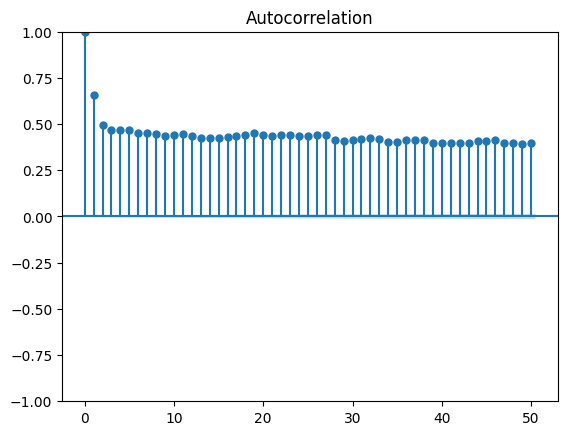

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['mean_visibility'].dropna(), lags=50)
plt.show()

Observation: 'mean_visibility' values are correlated with their immediate past values. This indicates a temporal dependency in the data, suggesting that nearby values have a strong influence on each other.
The ACF analysis suggests missing values can be better estimated using adjacent data points. Hence, we'll use interpolation to estimate missing values based on the surrounding data points.

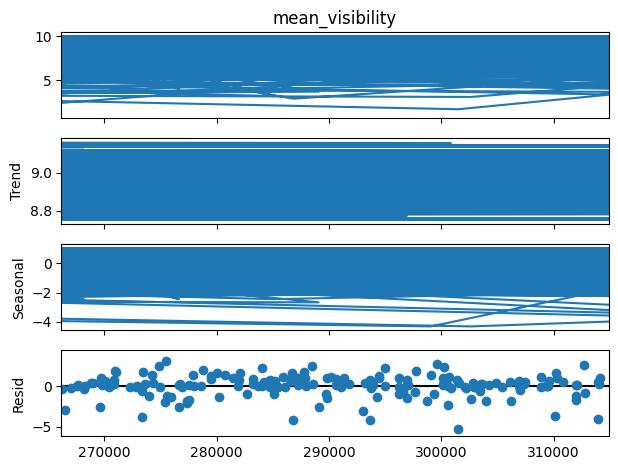

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Analysis
result = seasonal_decompose(df[df['station_number'] == 725300]['mean_visibility'].dropna(), model='additive', period=365)
result.plot()
plt.show()

In [31]:
df_new['mean_visibility'] = df['mean_visibility'].interpolate(method='linear')

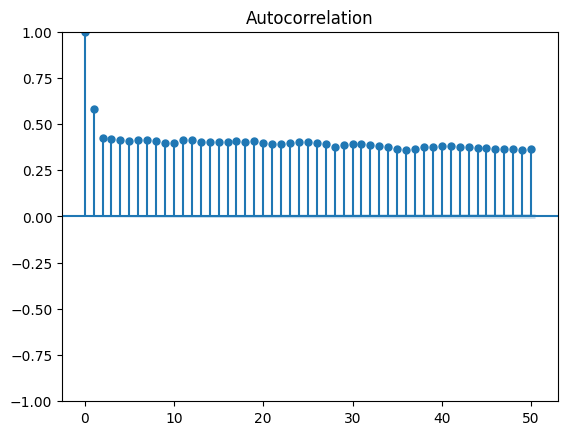

In [64]:
plot_acf(df['mean_wind_speed'].dropna(), lags=50)
plt.show()

In [23]:
df_new['mean_wind_speed'] = df['mean_wind_speed'].interpolate(method='linear')

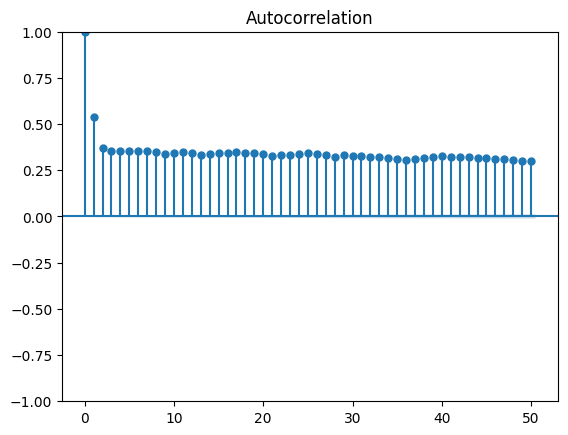

In [66]:
plot_acf(df['max_sustained_wind_speed'].dropna(), lags=50)
plt.show()

In [24]:
df_new['max_sustained_wind_speed'] = df['max_sustained_wind_speed'].interpolate(method='linear')

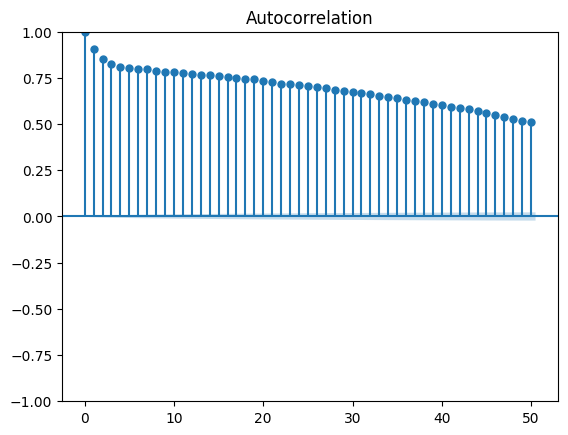

In [68]:
plot_acf(df['max_temperature'].dropna(), lags=50)
plt.show()

How does the autocorrelation of temperature vary over the year?

In [25]:
df_new['max_temperature'] = df['max_temperature'].interpolate(method='linear')

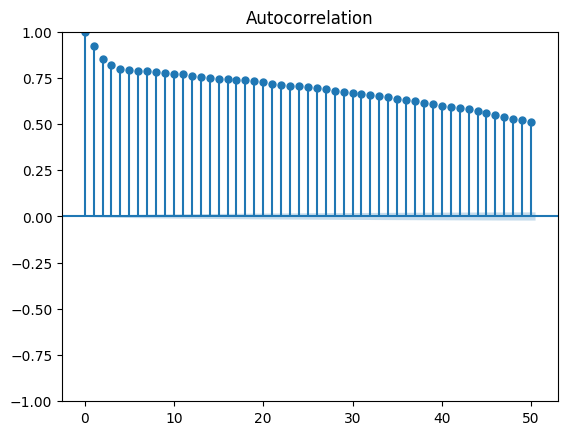

In [70]:
plot_acf(df['mean_dew_point'].dropna(), lags=50)
plt.show()

In [26]:
df_new['mean_dew_point'] = df['mean_dew_point'].interpolate(method='linear')

In [28]:
df_new.columns

Index(['station_number', 'wban_number', 'year', 'month', 'day', 'mean_temp',
       'num_mean_temp_samples', 'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_temperature', 'max_temperature_explicit', 'fog', 'rain', 'snow',
       'hail', 'thunder', 'tornado', 'date'],
      dtype='object')

In [29]:
df_new = df_new.drop(columns = ['num_mean_temp_samples', 
                                'num_mean_dew_point_samples', 
                                'num_mean_visibility_samples', 
                                'num_mean_wind_speed_samples', 
                                'max_temperature_explicit'])

In [32]:
df_new.isna().sum()

station_number              0
wban_number                 0
year                        0
month                       0
day                         0
mean_temp                   0
mean_dew_point              0
mean_visibility             0
mean_wind_speed             0
max_sustained_wind_speed    0
max_temperature             0
fog                         0
rain                        0
snow                        0
hail                        0
thunder                     0
tornado                     0
date                        0
dtype: int64

In [28]:
df_new['station_number'].value_counts()

station_number
726284    1824
725570    1824
725720    1824
725780    1824
725485    1824
          ... 
725765     449
725848     198
725786     138
725643       1
725646       1
Name: count, Length: 217, dtype: Int64

There are 217 unique stations in the dataset. 

In [33]:
df_new_726284 = df_new[df_new['station_number'] == 726284]

### Correlations

Check correlations between the target (snow) and data.

#### Correlation with numerical features

Point-Biserial Correlation is used when you want to measure the relationship between a continuous variable and a dichotomous variable, or one that has two values

Our target variable 'snow' is binary (snow or no snow). Point-Biserial Correlation provides a measure of the strength and direction of the association between the binary outcome (snow) and continuous predictor variables (e.g., temperature, dew point, visibility).

In [35]:
from scipy.stats import pointbiserialr, pearsonr

numerical_cols = ['mean_temp', 'mean_dew_point',
                  'mean_visibility', 'mean_wind_speed',
                  'max_sustained_wind_speed', 'max_temperature']

# Correlation between numerical features and the target
correlation_results = {}
for col in numerical_cols:
    correlation, p_value = pointbiserialr(df_new_726284['snow'], df_new_726284[col])
    correlation_results[col] = correlation
print("Point-Biserial Correlation with 'snow':")
correlation_results

Point-Biserial Correlation with 'snow':


{'mean_temp': 0.08487545314685332,
 'mean_dew_point': 0.16270160915997212,
 'mean_visibility': -0.4007360699537347,
 'mean_wind_speed': -0.033881367980419096,
 'max_sustained_wind_speed': -0.04190256506026076,
 'max_temperature': 0.1092125772285649}

Observation: 

- mean_dew_point: There is a weak positive correlation between mean dew point and snowfall. Higher dew points, which indicate higher humidity, are often necessary for snow formation, as they suggest more moisture in the air.
- mean_visibility: There is a strong negative correlation between mean visibility and snowfall. This suggests that lower visibility is strongly associated with snowfall, likely because snow reduces visibility due to the density of the falling snow and accumulation.
- max_temperature: There is a weak positive correlation between maximum temperature and snowfall. This could suggest that snowfall is slightly more likely when maximum temperatures are around the freezing point.

In [36]:
# Pearson correlation between numerical features
pearson_corr = df_new_726284[numerical_cols].corr()
print("Pearson Correlation between numerical features:\n")
pearson_corr

Pearson Correlation between numerical features:



,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,max_sustained_wind_speed,max_temperature
mean_temp,1.000000,0.963891,0.248235,-0.027752,0.040795,0.971798
mean_dew_point,0.963891,1.000000,0.106632,-0.016268,0.031442,0.970738
mean_visibility,0.248235,0.106632,1.000000,-0.243291,-0.150610,0.155946
mean_wind_speed,-0.027752,-0.016268,-0.243291,1.000000,0.827096,0.049859
max_sustained_wind_speed,0.040795,0.031442,-0.150610,0.827096,1.000000,0.072681
max_temperature,0.971798,0.970738,0.155946,0.049859,0.072681,1.000000


Observation: 
- mean_temp and mean_dew_point (0.963891): A high correlation suggests that warmer conditions typically coincide with higher moisture content in the air.
- mean_temp and max_temperature (0.971798): The very high correlation suggests that mean and maximum temperatures move together closely, as expected since they are both measures of temperature.
- mean_temp and mean_visibility (0.248235): There is a moderate positive relationship, suggesting that higher temperatures might be slightly associated with better visibility.
- mean_visibility and mean_wind_speed (-0.243291): A moderate negative correlation suggests that higher wind speeds are associated with lower visibility, possibly due to blowing snow or dust reducing visibility.

In [37]:
df_new = df_new.drop(columns = ['max_sustained_wind_speed', 'max_temperature'])

#### Correlation with categorical features

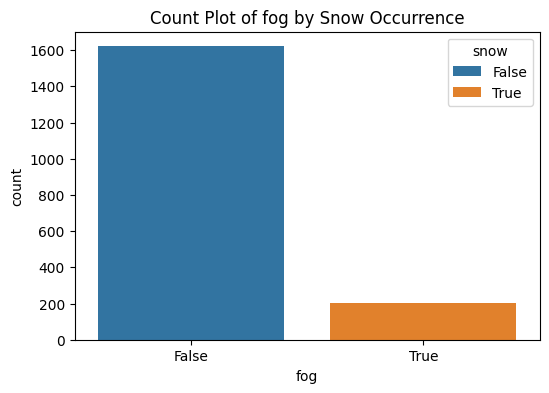

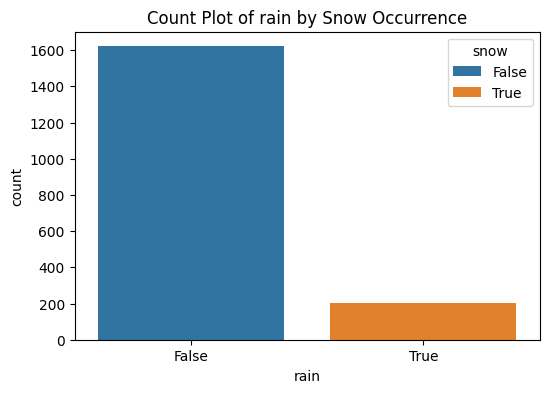

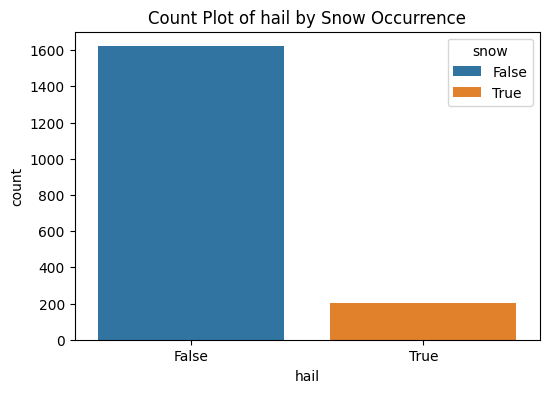

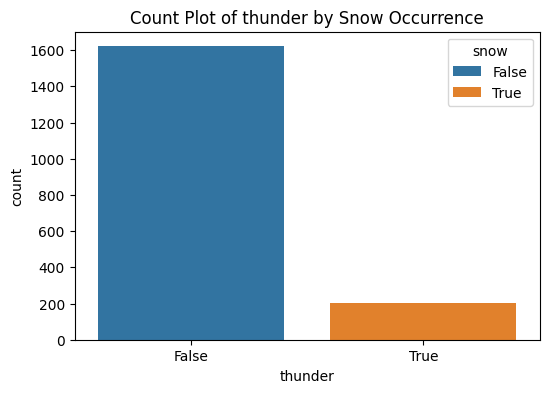

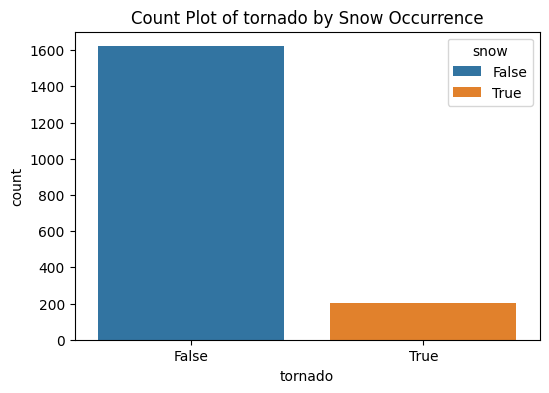

In [81]:
import seaborn as sns
categorical_cols = ['fog', 'rain', 'hail', 'thunder', 'tornado']
# Countplot for categorical vs target
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='snow', data=df_new_726284)
    plt.title(f'Count Plot of {col} by Snow Occurrence')
    plt.show()

In [52]:
df_new_725643 = df_new[df_new['station_number'] == 725485]

categorical_cols = ['fog', 'rain', 'hail', 'thunder', 'tornado']

# Filter dataframe for rows where snow is True
snow_true_df = df_new_725643[df_new_725643['snow'] == True]

# Calculate occurrences and proportions
for col in categorical_cols:
    count_both_true = snow_true_df[snow_true_df[col] == True].shape[0]
    total_snow_true = snow_true_df.shape[0]
    proportion = count_both_true / df_new_725643['snow'].shape[0]
    print(f'Occurrences where snow=True and {col}=True: {count_both_true}')
    print(f'Proportion of {col}=True out of all snow=True: {proportion:.2f}')

Occurrences where snow=True and fog=True: 420
Proportion of fog=True out of all snow=True: 0.23
Occurrences where snow=True and rain=True: 420
Proportion of rain=True out of all snow=True: 0.23
Occurrences where snow=True and hail=True: 420
Proportion of hail=True out of all snow=True: 0.23
Occurrences where snow=True and thunder=True: 420
Proportion of thunder=True out of all snow=True: 0.23
Occurrences where snow=True and tornado=True: 420
Proportion of tornado=True out of all snow=True: 0.23


In [98]:
df_new_725780 = df_new[df_new['station_number'] == 725780]
snow_true_df = df_new_725780[df_new_725780['snow'] == True]
snow_true_df.head(20)

,station_number,month,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,fog,rain,snow,hail,...,mean_visibility_lag_4,mean_wind_speed_lag_4,mean_temp_rolling_mean_7,mean_visibility_rolling_mean_7,mean_wind_speed_rolling_mean_7,temp_dew_point_diff,temp_visibility_product,fog_rain,hail_thunder,snow_next_day
243641,725780,1,25.000000,21.299999,8.5,5.800000,True,True,True,True,...,8.5,5.800000,21.771429,6.928572,5.685714,3.700001,212.500000,True,True,1
213909,725780,1,18.600000,15.300000,9.1,2.300000,True,True,True,True,...,8.5,5.800000,21.771429,6.928572,5.685714,3.300000,169.260011,True,True,1
351663,725780,1,23.299999,21.400000,4.3,1.100000,True,True,True,True,...,8.5,5.800000,21.771429,6.928572,5.685714,1.900000,100.190001,True,True,1
331965,725780,1,24.299999,22.000000,4.3,7.500000,True,True,True,True,...,8.5,5.800000,21.771429,6.928572,5.685714,2.299999,104.490001,True,True,1
168136,725780,1,20.900000,17.299999,7.2,9.300000,True,True,True,True,...,8.5,5.800000,21.771429,6.928572,5.685714,3.600000,150.479993,True,True,1
341929,725780,1,20.200001,17.500000,6.3,8.800000,True,True,True,True,...,9.1,2.300000,21.771429,6.928572,5.685714,2.700001,127.260009,True,True,1
108807,725780,1,20.100000,14.800000,8.8,5.000000,True,True,True,True,...,4.3,1.100000,21.771429,6.928572,5.685714,5.300000,176.880007,True,True,1
210783,725780,1,31.900000,26.400000,4.5,23.200001,True,True,True,True,...,4.3,7.500000,22.757143,6.357143,8.171429,5.500000,143.549998,True,True,1
112198,725780,1,31.000000,26.200001,7.4,7.100000,True,True,True,True,...,7.2,9.300000,24.528571,6.114286,8.857143,4.799999,229.400003,True,True,1
141796,725780,1,27.400000,25.000000,7.3,2.100000,True,True,True,True,...,6.3,8.800000,25.114286,6.542857,9.000000,2.400000,200.020002,True,True,1


### Feature Engineering

In [53]:
import pandas as pd
import numpy as np

df_new['date'] = pd.to_datetime(df_new['date'])
df_new = df_new.sort_values(by=['station_number', 'date'])

# Temporal Features
df_new['day_of_year'] = df_new['date'].dt.dayofyear

In [54]:
df_new.head()

,station_number,wban_number,year,month,day,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,fog,rain,snow,hail,thunder,tornado,date,day_of_year
266180,725300,94846,2005,1,1,32.099998,21.200001,9.9,8.7,False,False,False,False,False,False,2005-01-01,1
374797,725300,94846,2005,1,2,42.799999,40.099998,6.1,9.4,True,True,True,True,True,True,2005-01-02,2
145316,725300,94846,2005,1,3,34.599998,31.600000,6.3,7.8,True,True,True,True,True,True,2005-01-03,3
342,725300,94846,2005,1,4,32.299999,29.400000,7.7,9.3,True,True,True,True,True,True,2005-01-04,4
240186,725300,94846,2005,1,5,29.700001,26.900000,2.0,15.4,True,True,True,True,True,True,2005-01-05,5


In [55]:
# Lag Features
for lag in range(1, 5):  # Last 4 days
    df_new[f'mean_temp_lag_{lag}'] = df_new.groupby('station_number')['mean_temp'].shift(lag)
    df_new[f'mean_visibility_lag_{lag}'] = df_new.groupby('station_number')['mean_visibility'].shift(lag)
    df_new[f'mean_wind_speed_lag_{lag}'] = df_new.groupby('station_number')['mean_wind_speed'].shift(lag)

In [56]:
# Rolling Statistics
df_new['mean_temp_rolling_mean_7'] = df_new.groupby('station_number')['mean_temp'].rolling(window=7).mean().reset_index(level=0, drop=True)
df_new['mean_visibility_rolling_mean_7'] = df_new.groupby('station_number')['mean_visibility'].rolling(window=7).mean().reset_index(level=0, drop=True)
df_new['mean_wind_speed_rolling_mean_7'] = df_new.groupby('station_number')['mean_wind_speed'].rolling(window=7).mean().reset_index(level=0, drop=True)

In [57]:
# Interaction Features

# Combine temperature and humidity to create feature heat index.
df_new['temp_dew_point_diff'] = df_new['mean_temp'] - df_new['mean_dew_point']
df_new['temp_visibility_product'] = df_new['mean_temp'] * df_new['mean_visibility']

In [58]:
# Weather Events Combinations
df_new['fog_rain'] = df_new['fog'] & df_new['rain']
df_new['hail_thunder'] = df_new['hail'] & df_new['thunder']

In [59]:
df_new.isna().sum()

station_number                       0
wban_number                          0
year                                 0
month                                0
day                                  0
mean_temp                            0
mean_dew_point                       0
mean_visibility                      0
mean_wind_speed                      0
fog                                  0
rain                                 0
snow                                 0
hail                                 0
thunder                              0
tornado                              0
date                                 0
day_of_year                          0
mean_temp_lag_1                    217
mean_visibility_lag_1              217
mean_wind_speed_lag_1              217
mean_temp_lag_2                    432
mean_visibility_lag_2              432
mean_wind_speed_lag_2              432
mean_temp_lag_3                    647
mean_visibility_lag_3              647
mean_wind_speed_lag_3    

In [60]:
# List of columns with rolling statistics or other missing values
columns_to_fill = ['mean_temp_lag_1', 'mean_visibility_lag_1', 'mean_wind_speed_lag_1',
       'mean_temp_lag_2', 'mean_visibility_lag_2', 'mean_wind_speed_lag_2',
       'mean_temp_lag_3', 'mean_visibility_lag_3', 'mean_wind_speed_lag_3',
       'mean_temp_lag_4', 'mean_visibility_lag_4', 'mean_wind_speed_lag_4',
       'mean_temp_rolling_mean_7', 'mean_visibility_rolling_mean_7',
       'mean_wind_speed_rolling_mean_7']

# Apply forward and backward fill to all specified columns within each station using transform
for column in columns_to_fill:
    df_new[column] = df_new.groupby('station_number')[column].transform(lambda x: x.ffill().bfill())

# Display the first few rows of the filled dataframe
df_new.head()

,station_number,wban_number,year,month,day,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,fog,...,mean_temp_lag_4,mean_visibility_lag_4,mean_wind_speed_lag_4,mean_temp_rolling_mean_7,mean_visibility_rolling_mean_7,mean_wind_speed_rolling_mean_7,temp_dew_point_diff,temp_visibility_product,fog_rain,hail_thunder
266180,725300,94846,2005,1,1,32.099998,21.200001,9.9,8.7,False,...,32.099998,9.9,8.7,30.771428,6.414286,9.742857,10.899998,317.789973,False,False
374797,725300,94846,2005,1,2,42.799999,40.099998,6.1,9.4,True,...,32.099998,9.9,8.7,30.771428,6.414286,9.742857,2.700001,261.079991,True,True
145316,725300,94846,2005,1,3,34.599998,31.600000,6.3,7.8,True,...,32.099998,9.9,8.7,30.771428,6.414286,9.742857,2.999998,217.979997,True,True
342,725300,94846,2005,1,4,32.299999,29.400000,7.7,9.3,True,...,32.099998,9.9,8.7,30.771428,6.414286,9.742857,2.900000,248.709988,True,True
240186,725300,94846,2005,1,5,29.700001,26.900000,2.0,15.4,True,...,32.099998,9.9,8.7,30.771428,6.414286,9.742857,2.800001,59.400002,True,True


In [61]:
df_new = df_new.drop(columns = ['wban_number', 'year', 'day'])

### Model Selection and Evaluation

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for should constitute your test set.

In [99]:
from datetime import datetime, timedelta

str(dt.datetime.today()- dt.timedelta(days=15*365)).split(' ')[0]

'2009-06-22'

In [75]:
# Shift the target variable 'snow' one timestep forward
df_new['snow_next_day'] = df_new['snow'].shift(-1)

# Drop rows where 'snow_next_day' is NaN
df_new = df_new.dropna(subset=['snow_next_day'])

# Convert 'snow_next_day' to integer if necessary
df_new['snow_next_day'] = df_new['snow_next_day'].astype(int)

/var/folders/82/7wj62gm970vc14cb8fmyr8140000gn/T/ipykernel_25305/3276429594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['snow_next_day'] = df_new['snow'].shift(-1)


In [76]:
# Determine the test date: 15 years ago from today
today = dt.datetime.now()
test_date = today - timedelta(days=15*365)

# Convert test_date to just the date part (ignore time)
test_date = test_date.date()

# Create the test set: data for the specific date 15 years ago from today
test_set = df_new[df_new['date'].dt.date == test_date].copy()

# Ensure test_set is not empty
if test_set.empty:
    raise ValueError(f"No data available for the test date: {test_date}")

# Create the training and evaluation sets: data before the test date
train_eval_set = df_new[df_new['date'].dt.date < test_date]

# Further split train_eval_set into training and evaluation sets (e.g., 80% train, 20% eval)
train_size = int(len(train_eval_set) * 0.8)
train_set = train_eval_set[:train_size]
eval_set = train_eval_set[train_size:]

# Display the sizes of the sets
print(f"Training set size: {len(train_set)}")
print(f"Evaluation set size: {len(eval_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 270326
Evaluation set size: 67582
Test set size: 207


## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [100]:
import datetime as dt

str(dt.datetime.today()- dt.timedelta(days=15*365)).split(' ')[0]

'2009-06-22'

You are allowed to use any library you are comfortable with such as sklearn, tensorflow, keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Define features and target variable
features = df_new.drop(columns = ['snow_next_day', 'station_number', 'date']).columns

target = 'snow_next_day'

# Split into features (X) and target (y) for each set
X_train = train_set[features]
y_train = train_set[target]

X_eval = eval_set[features]
y_eval = eval_set[target]

X_test = test_set[features]
y_test = test_set[target]

print(y_train.value_counts())

snow_next_day
0    247221
1     23105
Name: count, dtype: int64


In [103]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
X_test_scaled = scaler.transform(X_test)

# Train a decision tree classifier with class weights
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate the classifier on the evaluation set
y_eval_pred = clf.predict(X_eval_scaled)
eval_accuracy = accuracy_score(y_eval, y_eval_pred)
print(f"Evaluation Accuracy: {eval_accuracy}")
print("Classification Report for Evaluation Set:")
print(classification_report(y_eval, y_eval_pred))

# Test the classifier on the test set
y_test_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

# Optionally, print the confusion matrix for a detailed view of performance
print("Confusion Matrix for Evaluation Set:")
print(confusion_matrix(y_eval, y_eval_pred))

print("Confusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_test_pred))

Evaluation Accuracy: 0.7744961676185966
Classification Report for Evaluation Set:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     55180
           1       0.29      0.16      0.20     12402

    accuracy                           0.77     67582
   macro avg       0.56      0.54      0.54     67582
weighted avg       0.73      0.77      0.75     67582

Test Accuracy: 0.8888888888888888
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       191
           1       0.18      0.12      0.15        16

    accuracy                           0.89       207
   macro avg       0.56      0.54      0.54       207
weighted avg       0.87      0.89      0.88       207

Confusion Matrix for Evaluation Set:
[[50378  4802]
 [10438  1964]]
Confusion Matrix for Test Set:
[[182   9]
 [ 14   2]]


#### Training with hyper-parameter optimizaiton

In [72]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Assuming df_new is your dataframe and it's already processed
df_new['date'] = pd.to_datetime(df_new['date'])

# Shift the target variable for prediction
df_new['snow_next_day'] = df_new.groupby('station_number')['snow'].shift(-1)

# Drop rows with NaN in the target variable after shift
df_new = df_new.dropna(subset=['snow_next_day'])

# Convert target variable to integer
df_new['snow_next_day'] = df_new['snow_next_day'].astype(int)

# Define features and target variable
features = df_new.drop(columns = ['date', 'station_number', 'snow_next_day']).columns

target = 'snow_next_day'

# Determine the test date range: 15 years ago from today to 15 years ago + 1 year
today = datetime.now()
test_start_date = today - timedelta(days=15*365)
test_end_date = test_start_date + timedelta(days=365)

# Split the data into training, evaluation, and test sets
train_eval_set = df_new[df_new['date'] < test_start_date]
test_set = df_new[(df_new['date'] >= test_start_date) & (df_new['date'] < test_end_date)]

# Further split train_eval_set into training and evaluation sets (e.g., 80% train, 20% eval)
train_size = int(len(train_eval_set) * 0.8)
train_set = train_eval_set[:train_size]
eval_set = train_eval_set[train_size:]

# Display the sizes of the sets
print(f"Training set size: {len(train_set)}")
print(f"Evaluation set size: {len(eval_set)}")
print(f"Test set size: {len(test_set)}")

# Split into features (X) and target (y) for each set
X_train = train_set[features]
y_train = train_set[target]

X_eval = eval_set[features]
y_eval = eval_set[target]

X_test = test_set[features]
y_test = test_set[target]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
X_test_scaled = scaler.transform(X_test)

# Define the decision tree classifier with class weights and perform hyperparameter tuning
dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
dt_clf = DecisionTreeClassifier(class_weight='balanced')
grid_search_dt = GridSearchCV(dt_clf, dt_params, scoring='f1', cv=5)
grid_search_dt.fit(X_train_scaled, y_train)

best_dt_clf = grid_search_dt.best_estimator_

# Evaluate the best decision tree classifier on the evaluation set
y_eval_pred = best_dt_clf.predict(X_eval_scaled)
eval_accuracy = accuracy_score(y_eval, y_eval_pred)
print(f"Decision Tree Evaluation Accuracy: {eval_accuracy}")
print("Decision Tree Classification Report for Evaluation Set:")
print(classification_report(y_eval, y_eval_pred))

# Test the best decision tree classifier on the test set
y_test_pred = best_dt_clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Test Accuracy: {test_accuracy}")
print("Decision Tree Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

# Train a random forest classifier with class weights
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search_rf = GridSearchCV(rf_clf, rf_params, scoring='f1', cv=5)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_clf = grid_search_rf.best_estimator_

# Evaluate the best random forest classifier on the evaluation set
y_eval_pred_rf = best_rf_clf.predict(X_eval_scaled)
eval_accuracy_rf = accuracy_score(y_eval, y_eval_pred_rf)
print(f"Random Forest Evaluation Accuracy: {eval_accuracy_rf}")
print("Random Forest Classification Report for Evaluation Set:")
print(classification_report(y_eval, y_eval_pred_rf))

# Test the best random forest classifier on the test set
y_test_pred_rf = best_rf_clf.predict(X_test_scaled)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf}")
print("Random Forest Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred_rf))

# Optionally, print the confusion matrix for a detailed view of performance
print("Decision Tree Confusion Matrix for Evaluation Set:")
print(confusion_matrix(y_eval, y_eval_pred))

print("Decision Tree Confusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_test_pred))

print("Random Forest Confusion Matrix for Evaluation Set:")
print(confusion_matrix(y_eval, y_eval_pred_rf))

print("Random Forest Confusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_test_pred_rf))


Training set size: 269809
Evaluation set size: 67453
Test set size: 39659
Decision Tree Evaluation Accuracy: 0.7140527478392362
Decision Tree Classification Report for Evaluation Set:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81     55072
           1       0.34      0.60      0.44     12381

    accuracy                           0.71     67453
   macro avg       0.62      0.67      0.62     67453
weighted avg       0.79      0.71      0.74     67453

Decision Tree Test Accuracy: 0.8009783403514965
Decision Tree Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     35491
           1       0.24      0.41      0.30      4168

    accuracy                           0.80     39659
   macro avg       0.58      0.63      0.59     39659
weighted avg       0.85      0.80      0.82     39659

Random Forest Evaluation Accuracy: 0.8105347427097387
Random For